In [1]:
!pip install torchinfo
# !pip install -U "transformers==4.44.2" "huggingface_hub==0.24.6"

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
import torchinfo
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
MAX_LENGTH = 200 # every sentence can only have 512 words max
EMBEDDING_DIM = 104
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
from datasets import load_dataset, concatenate_datasets
from datasets import Value, DatasetDict

# IMDB: 50k long-form reviews
imdb = load_dataset("imdb")

# GLUE SST-2: 67k short movie review phrases
sst2 = load_dataset("glue", "sst2")
sst2 = sst2.rename_column("sentence", "text")

# StanfordNLP SST2: ~70k phrases, slightly different split
sst2_alt = load_dataset("stanfordnlp/sst2")
if "sentence" in sst2_alt["train"].column_names:
    sst2_alt = sst2_alt.rename_column("sentence", "text")


def ensure_int_label(example):
    example["label"] = int(example["label"])
    return example

imdb = imdb.map(ensure_int_label)
sst2 = sst2.map(ensure_int_label)
sst2_alt = sst2_alt.map(ensure_int_label)

def cast_int(ds):
    return ds.cast_column("label", Value("int64"))

if isinstance(imdb, DatasetDict):
    imdb["train"] = cast_int(imdb["train"])
    imdb["test"] = cast_int(imdb["test"])
else:
    imdb = cast_int(imdb)

if isinstance(sst2, DatasetDict):
    sst2["train"] = cast_int(sst2["train"])
    sst2["validation"] = cast_int(sst2["validation"])
else:
    sst2 = cast_int(sst2)

if isinstance(sst2_alt, DatasetDict):
    sst2_alt["train"] = cast_int(sst2_alt["train"])
    sst2_alt["validation"] = cast_int(sst2_alt["validation"])
else:
    sst2_alt = cast_int(sst2_alt)

train_mix = concatenate_datasets([
    imdb["train"],
    sst2["train"],
    sst2_alt["train"],
])

test_mix = concatenate_datasets([
    imdb["test"],
    sst2["validation"],
    sst2_alt["validation"],
])

train_mix = train_mix.shuffle(seed=42)
test_mix = test_mix.shuffle(seed=42)

dataset = DatasetDict({
    "train": train_mix,
    "test": test_mix
})

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'idx'],
        num_rows: 159698
    })
    test: Dataset({
        features: ['text', 'label', 'idx'],
        num_rows: 26744
    })
})

In [ ]:
def tokenize_fn(example):
    return tokenizer(example['text'],
                     padding="max_length",
                     max_length=MAX_LENGTH,
                     truncation=True)

tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset.set_format(type='torch')

In [8]:
tokenized_train = tokenized_dataset['train']
tokenized_test = tokenized_dataset['test']

tokenized_train, tokenized_test

(Dataset({
     features: ['text', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 159698
 }),
 Dataset({
     features: ['text', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 26744
 }))

In [9]:
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [10]:
train_loader = DataLoader(dataset=tokenized_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=tokenized_test, batch_size=64, shuffle=False, num_workers=2)


 EXPLORATORY DATA ANALYSIS (EDA) 

--- DATASET STATISTICS ---
Total Training Samples             : 159698
Total Testing Samples              : 26744
Train - Shortest Text (words)      : 1
Train - Longest Text (words)       : 2470
Train - Average Length (words)     : 44.53
Train - Median Length (words)      : 9.0
Train - Positive Labels            : 87638
Train - Negative Labels            : 72060


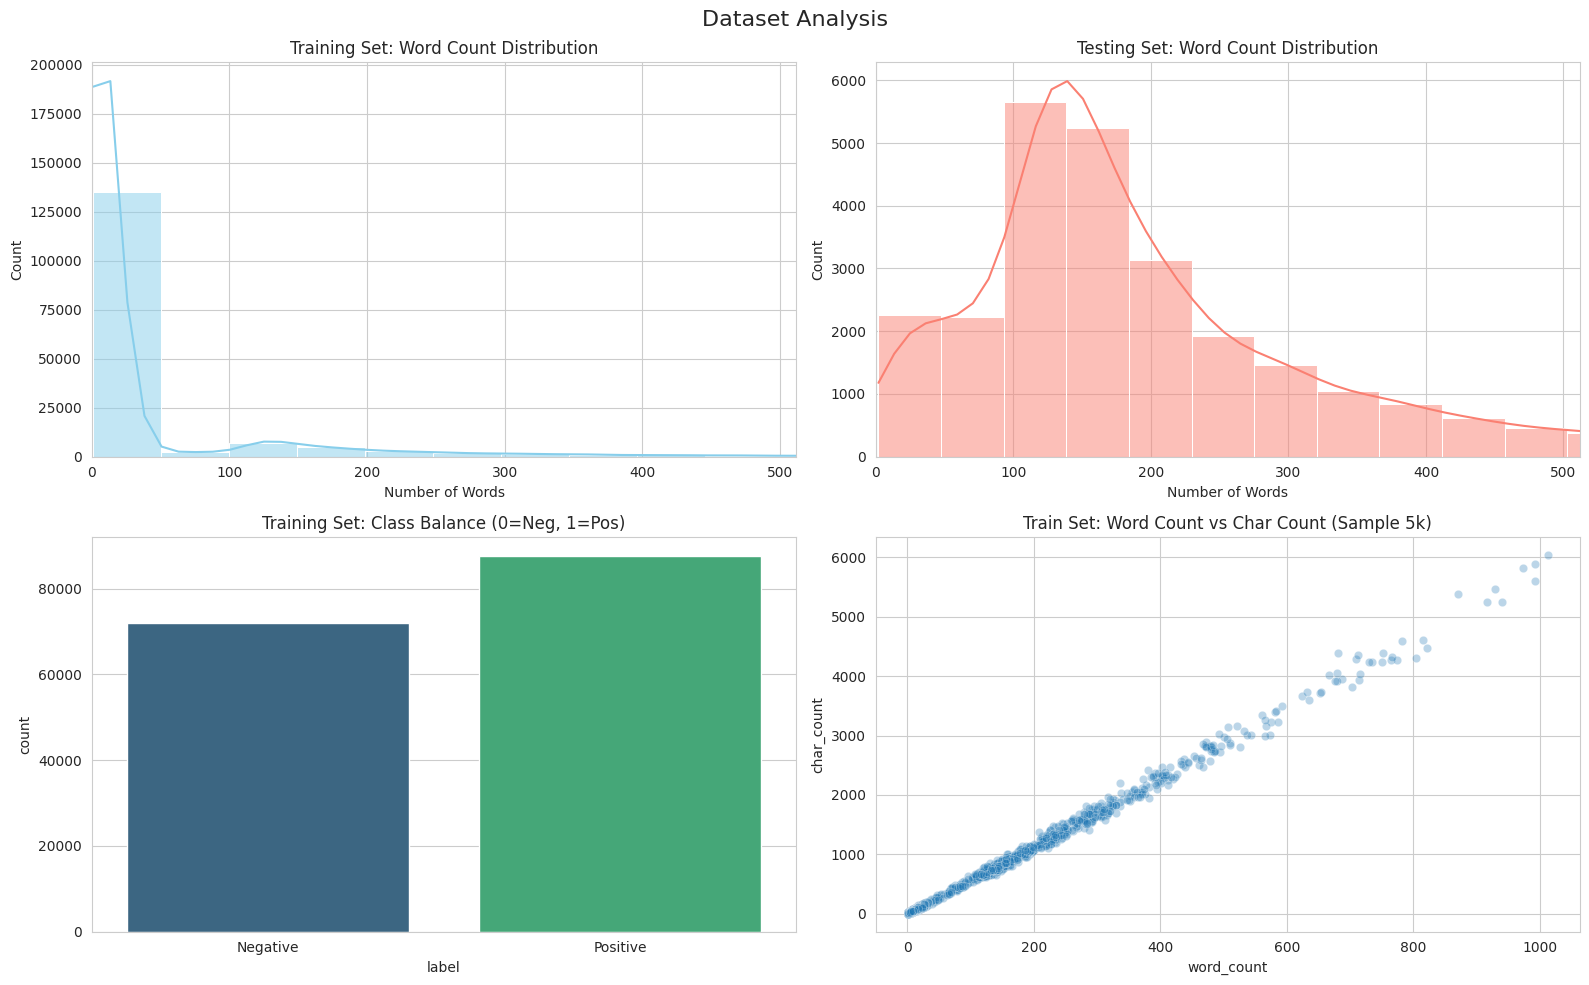

In [25]:
print("\n" + "="*40)
print(" EXPLORATORY DATA ANALYSIS (EDA) ")
print("="*40 + "\n")

def perform_eda(train_data, test_data):

    df_train = train_data.select_columns(['text', 'label']).to_pandas()
    df_test = test_data.select_columns(['text', 'label']).to_pandas()

    df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
    df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

    df_train['char_count'] = df_train['text'].apply(len)

    stats = {
        "Total Training Samples": len(df_train),
        "Total Testing Samples": len(df_test),
        "Train - Shortest Text (words)": df_train['word_count'].min(),
        "Train - Longest Text (words)": df_train['word_count'].max(),
        "Train - Average Length (words)": round(df_train['word_count'].mean(), 2),
        "Train - Median Length (words)": df_train['word_count'].median(),
        "Train - Positive Labels": len(df_train[df_train['label'] == 1]),
        "Train - Negative Labels": len(df_train[df_train['label'] == 0]),
    }

    print("--- DATASET STATISTICS ---")
    for key, value in stats.items():
        print(f"{key:<35}: {value}")

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Dataset Analysis', fontsize=16)

    sns.histplot(df_train['word_count'], bins=50, kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Training Set: Word Count Distribution')
    axes[0, 0].set_xlabel('Number of Words')
    axes[0, 0].set_xlim(0, 512)

    sns.histplot(df_test['word_count'], bins=50, kde=True, ax=axes[0, 1], color='salmon')
    axes[0, 1].set_title('Testing Set: Word Count Distribution')
    axes[0, 1].set_xlabel('Number of Words')
    axes[0, 1].set_xlim(0, 512)

    sns.countplot(x='label', hue='label', data=df_train, ax=axes[1, 0], palette='viridis', legend=False)
    axes[1, 0].set_title('Training Set: Class Balance (0=Neg, 1=Pos)')
    axes[1, 0].set_xticks([0, 1])
    axes[1, 0].set_xticklabels(['Negative', 'Positive'])


    sns.scatterplot(x='word_count', y='char_count', data=df_train.sample(n=min(5000, len(df_train))), ax=axes[1, 1], alpha=0.3)
    axes[1, 1].set_title('Train Set: Word Count vs Char Count (Sample 5k)')

    plt.tight_layout()
    plt.savefig('eda_sentiment_analysis.png')
    plt.show()


perform_eda(train_mix, test_mix)



> Model




In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, sequence_length, embedding_dim):
        super().__init__()
        position_matrix = torch.zeros((sequence_length, embedding_dim))

        rows = torch.arange(0, sequence_length).reshape(-1, 1)
        even_columns = torch.arange(0, embedding_dim, 2)

        denominator = torch.pow(10000, (even_columns.float() / embedding_dim))

        entries = rows/denominator

        position_matrix[:, ::2] = torch.sin(entries)
        position_matrix[:, 1::2] = torch.cos(entries)

        self.register_buffer('position_matrix', position_matrix)

    def forward(self, word_embedding):
        x_shape = word_embedding.shape #[batch, seq, embed_dim]

        pos = self.position_matrix[:x_shape[1], :]

        return word_embedding + pos

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, sequence_length):
        super().__init__()
        #num_embeddings is how many entries we have in the embedding matrix
        #embedding_dim is how long each embedding vector is in the embedding matrix

        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        #positional encoding
        self.positional_encoding = PositionalEncoding(sequence_length=sequence_length, embedding_dim=embedding_dim)

        #encoder layer
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8, dim_feedforward=2048, batch_first=True)

        self.encoder_stack = nn.TransformerEncoder(self.encoder_layer, num_layers=6)

        self.classifier = nn.Linear(in_features=embedding_dim, out_features=2) #takes in embedding dim, and outputs 2 choices (+, -)

    def forward(self, x, padding_mask):
        #get the word embeddings for the ids
        embeddings = self.embedding_layer(x)

        #add the positional encoding to the word embeddings
        embeddings_plus_position = self.positional_encoding(embeddings)


        # encoding = self.encoder_stack(embeddings_plus_position, src_key_padding_mask=~padding_mask)
        encoding = self.encoder_stack(embeddings_plus_position, src_key_padding_mask=torch.logical_not(padding_mask))
        # The output is now [batch_size, seq_length, embedding_dim]
        self.dropout = nn.Dropout(0.2)
        CLS_token = self.dropout(encoding[:,0,:]) #we want the first token (The CLS token which is just the summary of all the other context rich vectors in the sentence)
        # So now we have [batch_size, embedding_dim]

        output = self.classifier(CLS_token)

        return output



> Training Loop



In [ ]:
model = TextClassifier(vocab_size=tokenizer.vocab_size, embedding_dim=EMBEDDING_DIM, sequence_length=MAX_LENGTH).to(device)
model = torch.compile(model)

In [ ]:
torchinfo.summary(model)

Layer (type:depth-idx)                                                 Param #
OptimizedModule                                                        --
├─TextClassifier: 1-1                                                  --
│    └─Embedding: 2-1                                                  3,174,288
│    └─PositionalEncoding: 2-2                                         --
│    └─TransformerEncoderLayer: 2-3                                    --
│    │    └─MultiheadAttention: 3-1                                    43,680
│    │    └─Linear: 3-2                                                215,040
│    │    └─Dropout: 3-3                                               --
│    │    └─Linear: 3-4                                                213,096
│    │    └─LayerNorm: 3-5                                             208
│    │    └─LayerNorm: 3-6                                             208
│    │    └─Dropout: 3-7                                               --
│    │    

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.005)

In [ ]:
def get_accuracy(loader):
    model.eval()
    total_correct = 0

    with torch.no_grad():
        for batch in loader:
            X = batch['input_ids'].to(device)
            mask = batch['attention_mask'].bool().to(device)
            y = batch['label'].to(device)

            output = model(X, mask)
            total_correct += (torch.argmax(output,1) == y).sum().item()
    model.train()
    return total_correct / len(loader.dataset)


In [ ]:
scaler = torch.amp.GradScaler("cuda")

def train(epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0

        for batch in train_loader:
            X = batch['input_ids'].to(device)
            mask = batch['attention_mask'].bool().to(device)
            y = batch['label'].to(device)

            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                output = model(X, mask)
                loss = loss_fn(output, y)

            epoch_loss += loss.item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)

            scaler.update()

        print(f"Epoch {epoch + 1}   Training Loss= {epoch_loss/len(train_loader)} ", end="")
        print(f"   Train Accuracy={get_accuracy(train_loader)}   Test Accuracy= {get_accuracy(test_loader)}" if (epoch+1) % 5 == 0 else "")

In [ ]:
train(10)

Epoch 1   Training Loss= 0.5100580325397925 
Epoch 2   Training Loss= 0.31759124085641444 
Epoch 3   Training Loss= 0.2432815367833544 
Epoch 4   Training Loss= 0.19838611737419015 
Epoch 5   Training Loss= 0.16585937391545696    Train Accuracy=0.9573883204548586   Test Accuracy= 0.8100508525276697
Epoch 6   Training Loss= 0.14238897847751966 
Epoch 7   Training Loss= 0.12468794043748997 
Epoch 8   Training Loss= 0.11054382047045809 
Epoch 9   Training Loss= 0.10064033838436724 
Epoch 10   Training Loss= 0.0900825643270181    Train Accuracy=0.9817843679945898   Test Accuracy= 0.8195857014657493


In [ ]:
text = "This movie was not so bad!"
inputs = tokenizer(text, padding="max_length", max_length=MAX_LENGTH, truncation=True, return_tensors="pt")

inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    output = model(inputs['input_ids'], inputs['attention_mask'].bool())
    pred = torch.argmax(output, dim=1).item()

print("Prediction:", "Positive" if pred == 1 else "Negative", output)


Prediction: Positive tensor([[0.0050, 2.1282]], device='cuda:0')


In [ ]:
model.eval()
test_phrases = [
    "This movie was great!",
    "This movie was terrible!",
    "This movie was not great.",
    "This movie was not terrible.",
    "This movie was not bad at all!",
    "This is so good!",
    "This is not so good.",
    "It's so good I watched it twice.",
    "It's not so good, honestly.",
    "Okay but not so great.",
    "Surprisingly not so bad!"
]

for t in test_phrases:
    inputs = tokenizer(t, padding="max_length", max_length=MAX_LENGTH, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(inputs['input_ids'], inputs['attention_mask'].bool())
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred = "Positive" if probs[1] > 0.5 else "Negative"
    print(f"{t:<45} → {pred}  |  pos: {probs[1]:.3f}  neg: {probs[0]:.3f}")

This movie was great!                         → Positive  |  pos: 1.000  neg: 0.000
This movie was terrible!                      → Negative  |  pos: 0.000  neg: 1.000
This movie was not great.                     → Negative  |  pos: 0.008  neg: 0.992
This movie was not terrible.                  → Negative  |  pos: 0.004  neg: 0.996
This movie was not bad at all!                → Positive  |  pos: 0.917  neg: 0.083
This is so good!                              → Positive  |  pos: 0.999  neg: 0.001
This is not so good.                          → Negative  |  pos: 0.001  neg: 0.999
It's so good I watched it twice.              → Positive  |  pos: 0.999  neg: 0.001
It's not so good, honestly.                   → Negative  |  pos: 0.001  neg: 0.999
Okay but not so great.                        → Negative  |  pos: 0.079  neg: 0.921
Surprisingly not so bad!                      → Positive  |  pos: 0.981  neg: 0.019


In [ ]:
import torch

state_dict = {k.replace("_orig_mod.", ""): v for k, v in model.state_dict().items()}

inference_bundle = {
    "model_state_dict": state_dict,
    "config": {
        "tokenizer_name": "bert-base-uncased",
        "max_len": MAX_LENGTH,
        "embedding_dim": EMBEDDING_DIM,
        "vocab_size": tokenizer.vocab_size,
        "num_heads": 8,
        "num_layers": 6,
        "ff_dim": 2048,
        "classes": ["Negative", "Positive"],
    },
}

save_path = "custom_encoder_portable_model.pth"
torch.save(inference_bundle, save_path)

print(f"Saved portable model to: {save_path}")


Saved portable model to: custom_encoder_portable_model.pth
